![](https://images.pexels.com/photos/532192/pexels-photo-532192.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)

# Wind power forecasting
Wind energy is the energy of the wind transformed into useful energy through wind turbines. This renewable energy source is widely used because it is an alternative to fossil energy, it is clean, does not produce greenhouse gases and can generally be used in various locations, however there are still some environmental and social problems attached, such as soil compaction and the noise emitted by the blades. In addition, wind energy suffers a lot from the fluctuation of winds and, therefore, doors are opened for the application of Machine Learning models to be used to make generation forecasts. Finally, this project aims to forecast the wind power generation of a wind turbine located in Germany with historical data from 2011 to the end of 2021.

# Dictionary (Column)
- dt: Time series with timestep of 15 minutes.
- MW: Wind power (MW).
   
# References
- [kaggle dataset](https://www.kaggle.com/datasets/l3llff/wind-power)


### 1) Importing Libraries and Data loading

In [13]:
# Importing Libraries:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly as pl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import r_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Conv1D,  MaxPooling1D

import os
from datetime import datetime as dt

In [14]:
# Loading dataset
df = pd.read_csv("data.csv")

In [15]:
# Copy of the dataset:
dado_horarios = df.copy()

### 2) Exploratory Data Analysis

In [16]:
# Let's see the first five rows:
dado_horarios.head()

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


In [17]:
# Some information about data type and memory:
dado_horarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385566 entries, 0 to 385565
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   dt      385566 non-null  object 
 1   MW      385566 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.9+ MB


In [18]:
# Changing the type of the Time series column:
dado_horarios['dt'] = pd.to_datetime(dado_horarios['dt'])

In [19]:
# Dt column as index:
dado_horarios.set_index('dt', inplace=True)

In [20]:
# Some decriptive statistics:
dado_horarios.describe()

,MW
count,385566.000000
mean,3183.560481
std,3045.941591
min,0.000000
25%,905.000000
50%,2164.000000
75%,4529.877500
max,16727.500000


In [21]:
# Missing data:
dado_horarios.isna().sum()

MW    0
dtype: int64

As we can see above, there is no missing data.

In [22]:
# Aggregating information:
dado_horarios['month'] = dado_horarios.index.month
dado_horarios['year'] = dado_horarios.index.year

group = dado_horarios.groupby(["year", "month"]).mean().reset_index()

In [23]:
# Ploting the monthly average Wind Power by year:
fig = px.line(data_frame=group, x='month', y='MW', color='year', title="Monthly Average Wind power generation by year")
fig.show()

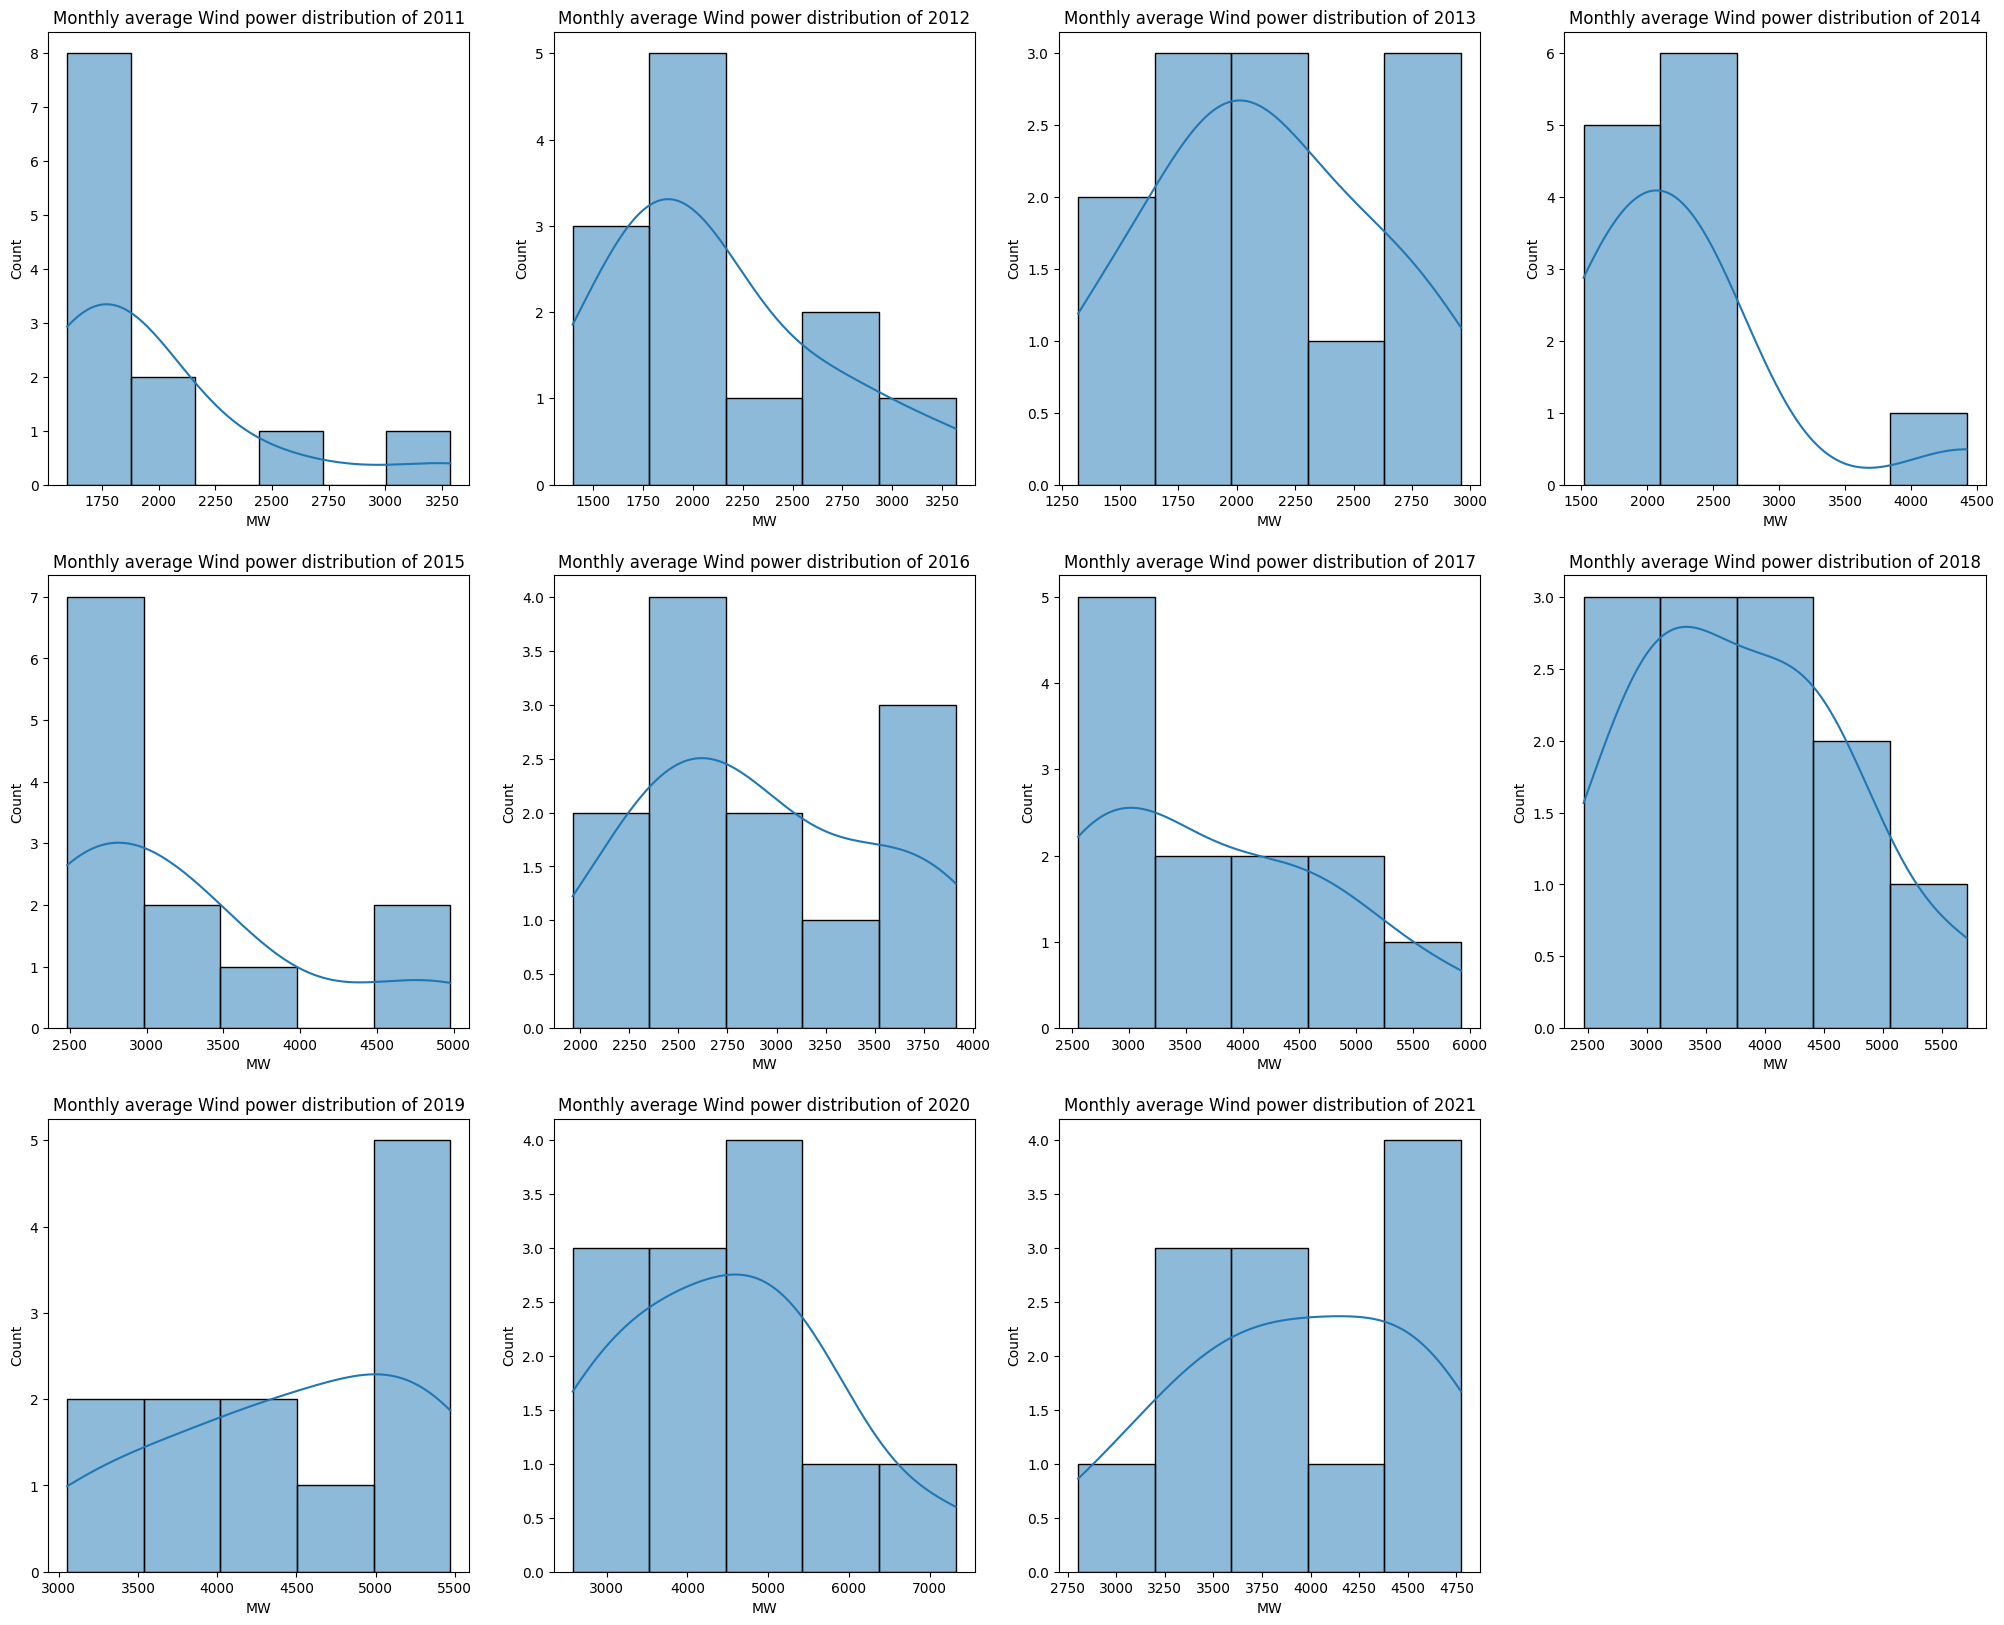

In [24]:
# Histograma da série temporal:
fig, ax = plt.subplots(ncols=4, nrows=3, sharex=False, sharey=False, figsize=(25, 20))

sns.histplot(x=group[group['year'] == 2011]['MW'], kde=True, ax=ax[0, 0])
sns.histplot(x=group[group['year'] == 2012]['MW'], kde=True, ax=ax[0, 1])
sns.histplot(x=group[group['year'] == 2013]['MW'], kde=True, ax=ax[0, 2])
sns.histplot(x=group[group['year'] == 2014]['MW'], kde=True, ax=ax[0, 3])
sns.histplot(x=group[group['year'] == 2015]['MW'], kde=True, ax=ax[1, 0])
sns.histplot(x=group[group['year'] == 2016]['MW'], kde=True, ax=ax[1, 1])
sns.histplot(x=group[group['year'] == 2017]['MW'], kde=True, ax=ax[1, 2])
sns.histplot(x=group[group['year'] == 2018]['MW'], kde=True, ax=ax[1, 3])
sns.histplot(x=group[group['year'] == 2019]['MW'], kde=True, ax=ax[2, 0])
sns.histplot(x=group[group['year'] == 2020]['MW'], kde=True, ax=ax[2, 1])
sns.histplot(x=group[group['year'] == 2021]['MW'], kde=True, ax=ax[2, 2])
ax[2, 3].set_visible(False)


ax[0, 0].set_title("Monthly average Wind power distribution of 2011")
ax[0, 1].set_title("Monthly average Wind power distribution of 2012")
ax[0, 2].set_title("Monthly average Wind power distribution of 2013")
ax[0, 3].set_title("Monthly average Wind power distribution of 2014")
ax[1, 0].set_title("Monthly average Wind power distribution of 2015")
ax[1, 1].set_title("Monthly average Wind power distribution of 2016")
ax[1, 2].set_title("Monthly average Wind power distribution of 2017")
ax[1, 3].set_title("Monthly average Wind power distribution of 2018")
ax[2, 0].set_title("Monthly average Wind power distribution of 2019")
ax[2, 1].set_title("Monthly average Wind power distribution of 2020")
ax[2, 2].set_title("Monthly average Wind power distribution of 2021")

plt.show()

In [ ]:
# Setting the time series column as index:
df.set_index('dt', inplace=True)

## 3) Preprocessing

The Class below has a method that can transform a dataset with a Time series structure into a dataset that can be used in a supervised manner.

In [ ]:
# Proprocessing class 
class Preprocessamento:

    def timeseries_to_supervised(self, df, n_features, n_target):
        n_linhas = 0
        colunas_features = ['var(t - {})'.format(str(i)) for i in range(n_features, -1, -1) if i != 0]
        colunas_target = ['var(t)' if i==0 else 'var(t + {})'.format(str(i)) for i in range(0, n_target)]
        colunas_total = colunas_features + colunas_target
        lista=[]
        
        while n_linhas <= len(df) - n_target - n_features:
            quantidade_de_features_iteracao = df.iloc[n_linhas:n_linhas + n_features].values
            quantidade_de_target_iteracao = df.iloc[n_linhas + n_features: n_linhas + n_features + n_target]
            
            linha = np.concatenate([quantidade_de_features_iteracao, quantidade_de_target_iteracao], axis=0)
            linha_reshape = linha.reshape(1, -1)
            lista.append(linha_reshape[0])
    
            n_linhas += 1
        df_iter = pd.DataFrame(lista, columns=colunas_total)

        return df_iter


In [ ]:
# Function that can plot several metrics:
def metricas(X_test, y_test, models):
    for name, model in models.items():
        if name == 'LSTM':
            y_pred = []
            for i in range(len(X_test)):
                X_test_linha = X_test[i, 0:]
                X_test_reshaped = X_test_linha.reshape(1, 1, len(X_test_linha))
                predicoes = model.predict(X_test_reshaped, batch_size=1, verbose=0)
                retorno = [x for x in predicoes[0]][0]
                y_pred.append(retorno)
            y_pred = np.array(y_pred)
        else:
            y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        coef_pearson = r_regression(y_pred.reshape(-1, 1), y_test)[0]
        print(f'{name}:')
        print(f'Mean squared error: {mse}')
        print(f'Root Mean squared error: {rmse}')
        print(f'Coef de pearson: {coef_pearson}')
        print('###########################################\n')

        return mse, rmse, coef_pearson

In [ ]:
# Separando os dados de treino inicial e teste:
percentagem_treino_inicial = 0.8

limite_treino_inicial = int(len(df)*percentagem_treino_inicial)
df_train_inicial = df.iloc[0:limite_treino_inicial]
df_test = df.iloc[limite_treino_inicial:]

In [ ]:
# Separando em dados de treino e validação:
percentagem_treino = 0.8

limite_treino = int(len(df_train_inicial)*percentagem_treino)
df_train = df_train_inicial.iloc[0:limite_treino]
df_val = df_train_inicial.iloc[limite_treino:]

In [ ]:
# Instancia um objeto de preprocessamento:
prep_obj = Preprocessamento()

In [ ]:
# Transformando os conjuntos em um modelo supervisionado:
n_features = 32
n_target = 12

df_train_supervised = prep_obj.timeseries_to_supervised(df_train, n_features, n_target)
df_val_supervised = prep_obj.timeseries_to_supervised(df_val, n_features, n_target)
df_test_supervised = prep_obj.timeseries_to_supervised(df_test, n_features, n_target)

In [ ]:
# Informações estatística sobre as features da base de dados:
df_train_supervised.describe()

,var(t - 32),var(t - 31),var(t - 30),var(t - 29),var(t - 28),var(t - 27),var(t - 26),var(t - 25),var(t - 24),var(t - 23),...,var(t + 2),var(t + 3),var(t + 4),var(t + 5),var(t + 6),var(t + 7),var(t + 8),var(t + 9),var(t + 10),var(t + 11)
count,246718.000000,246718.000000,246718.000000,246718.000000,246718.000000,246718.000000,246718.000000,246718.000000,246718.000000,246718.000000,...,246718.000000,246718.000000,246718.000000,246718.000000,246718.000000,246718.000000,246718.000000,246718.000000,246718.000000,246718.000000
mean,2629.470820,2629.481007,2629.484857,2629.483815,2629.485937,2629.487137,2629.487415,2629.486422,2629.485171,2629.483389,...,2629.352082,2629.344479,2629.337297,2629.330562,2629.323370,2629.316300,2629.308756,2629.300213,2629.291255,2629.282775
std,2577.737219,2577.745293,2577.749177,2577.748296,2577.750412,2577.751584,2577.751863,2577.750865,2577.749577,2577.747739,...,2577.592438,2577.582932,2577.573949,2577.565591,2577.556599,2577.547623,2577.538307,2577.527960,2577.517367,2577.507614
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,...,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000
50%,1755.710000,1755.710000,1755.710000,1755.710000,1755.710000,1755.710000,1755.710000,1755.710000,1755.710000,1755.710000,...,1755.710000,1755.710000,1755.710000,1755.710000,1755.710000,1755.710000,1755.710000,1755.710000,1755.710000,1755.710000
75%,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,...,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000,3720.000000
max,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,...,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000,14266.070000


In [ ]:
# Separando em features e target.
X_train, y_train = df_train_supervised.values[:, 0:n_features], df_train_supervised.values[:, n_features:]
X_val, y_val = df_val_supervised.values[:, 0:n_features], df_val_supervised.values[:, n_features:]
X_test, y_test = df_test_supervised.values[:, 0:n_features], df_test_supervised.values[:, n_features:]

In [ ]:
# Features shape:
print('Feature shapes:')
print(f'Training: {X_train.shape}')
print(f'Validation: {X_val.shape}')
print(f'Test: {X_test.shape}')
print('#########################\n')

# Target shape:
print('Target shapes:')
print(f'Training: {y_train.shape}')
print(f'Validation: {y_val.shape}')
print(f'Test: {y_test.shape}')


Feature shapes:
Training: (246718, 32)
Validation: (61648, 32)
Test: (77071, 32)
#########################

Target shapes:
Training: (246718, 12)
Validation: (61648, 12)
Test: (77071, 12)


### 3.1) Data transformation

#### 3.1.1) Min Max Scale

In [ ]:
# Fitting a Min Max scaler object:
scaler = MinMaxScaler()
scaler.fit(X_train)

# Transforming all the sets:
X_train_min_max = scaler.transform(X_train)
X_val_min_max = scaler.transform(X_val)
X_test_min_max = scaler.transform(X_test)

#### 3.1.2) Standard Scale

In [ ]:
# Fitting a Standard Scaler object:
std_scaler = StandardScaler()
std_scaler.fit(X_train)

# Transforming all the sets:
X_train_std = std_scaler.transform(X_train) 
X_val_std = std_scaler.transform(X_val)
X_test_std = std_scaler.transform(X_test)

#### 3.1.3) Robust Scale

In [ ]:
# Fitting a Standard Scaler object:
rb_scaler = RobustScaler()
rb_scaler.fit(X_train)

# Transforming all the sets:
X_train_rb = rb_scaler.transform(X_train) 
X_val_rb = rb_scaler.transform(X_val)
X_test_rb = rb_scaler.transform(X_test)

## 4) Fitting models

In [ ]:
# Directory name:
directory = dt.now().strftime("%Y-%m-%d__%H_%M_%S")

In [ ]:
# EarlyStopping callback:
earlystopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

### 4.1) Multilayer Neural Network

In [ ]:
# Function that structure a simple neural network architecture:
def mlp_simples(device):

    with tf.device(device):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(30, activation='sigmoid', input_shape=X_train.shape[1:]),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['mse'])
        
    return model

In [ ]:
# Making a directory for MLP models:
path_modelos_mlp_simples = "modelos_mlp_simples/{}".format(directory)
os.mkdir(path_modelos_mlp_simples)

# Training a MLP:
for target in range(n_target):
    
    checkpoint_mlp = tf.keras.callbacks.ModelCheckpoint('modelos_mlp_simples/{}/model{}_mlp.h5'.format(directory, target))
    model_mlp = mlp_simples('/device:GPU:0')
    history_2 = model_mlp.fit(X_train_min_max, y_train[:, target], epochs=60, 
                    validation_data=(X_val_min_max, y_val[:, target]), callbacks=[earlystopping, checkpoint_mlp])
    

Epoch 1/60
7710/7710 [==============================] - 14s 2ms/step - loss: 6656778.0000 - mse: 6656778.0000 - val_loss: 14481600.0000 - val_mse: 14481600.0000
Epoch 2/60
  59/7710 [..............................] - ETA: 13s - loss: 6645926.0000 - mse: 6645926.0000

c:\Users\caios\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



7710/7710 [==============================] - 11s 1ms/step - loss: 6652627.5000 - mse: 6652627.5000 - val_loss: 14112540.0000 - val_mse: 14112540.0000
Epoch 3/60
7710/7710 [==============================] - 11s 1ms/step - loss: 6652758.5000 - mse: 6652758.5000 - val_loss: 14166694.0000 - val_mse: 14166694.0000
Epoch 4/60
7710/7710 [==============================] - 11s 1ms/step - loss: 6653266.5000 - mse: 6653266.5000 - val_loss: 14021497.0000 - val_mse: 14021497.0000
Epoch 5/60
7710/7710 [==============================] - 10s 1ms/step - loss: 6652444.0000 - mse: 6652444.0000 - val_loss: 14310127.0000 - val_mse: 14310127.0000
Epoch 6/60
7710/7710 [==============================] - 10s 1ms/step - loss: 6652745.5000 - mse: 6652745.5000 - val_loss: 14020871.0000 - val_mse: 14020871.0000
Epoch 7/60
7710/7710 [==============================] - 9s 1ms/step - loss: 6652520.0000 - mse: 6652520.0000 - val_loss: 14123360.0000 - val_mse: 14123360.0000
Epoch 8/60
7710/7710 [========================

In [ ]:
# Metrics for each horizon for MLP:
resultados_mlp = []
path = "modelos_mlp_simples/{}".format(directory)

for target, i in enumerate(os.listdir(path)):
    path_temp = path + "/" + str(i)
    modelo_carregado = tf.keras.models.load_model(path_temp)
    mse, rmse, coef_p = metricas(X_test_min_max, y_test[:, target], {'mlp':modelo_carregado})
    resultados_mlp.append([mse, rmse, coef_p])

109/109 [==============================] - 0s 997us/step
mlp:
Mean squared error: 243.79324228571454
Root Mean squared error: 15.613879796056922
Coef de pearson: 0.9643117980309417
###########################################

109/109 [==============================] - 0s 988us/step
mlp:
Mean squared error: 1028.9322066296768
Root Mean squared error: 32.0769731525541
Coef de pearson: 0.8609330659908716
###########################################

109/109 [==============================] - 0s 1ms/step
mlp:
Mean squared error: 1279.0832574569213
Root Mean squared error: 35.764273478667526
Coef de pearson: 0.7981236693540822
###########################################

109/109 [==============================] - 0s 2ms/step
mlp:
Mean squared error: 1228.8368158702322
Root Mean squared error: 35.05476880354843
Coef de pearson: 0.8121894578972363
###########################################

109/109 [==============================] - 0s 1ms/step
mlp:
Mean squared error: 1488.5325913341337
Root

### 4.2) Random Forest

In [ ]:
# Traning Random Forest models for each horizon:
resultados_rnd = []
for target in range(n_target):
    rnd_model = RandomForestRegressor(random_state=42)
    rnd_model.fit(X_train_min_max, y_train[:, target])
    mse, rmse, coef_p = metricas(X_test_min_max, y_test[:, target], {'rnd':rnd_model})
    resultados_rnd.append([mse, rmse, coef_p])


rnd:
Mean squared error: 192.22459825585508
Root Mean squared error: 13.86450858328037
Coef de pearson: 0.970463800446502
###########################################

rnd:
Mean squared error: 528.1308927901837
Root Mean squared error: 22.981098598417432
Coef de pearson: 0.9168737028383905
###########################################

rnd:
Mean squared error: 846.1669928948725
Root Mean squared error: 29.088949669846667
Coef de pearson: 0.8634262109012374
###########################################

rnd:
Mean squared error: 1119.7302737163307
Root Mean squared error: 33.462371011575534
Coef de pearson: 0.8152878724877809
###########################################

rnd:
Mean squared error: 1357.8694969458509
Root Mean squared error: 36.84928081992715
Coef de pearson: 0.7709810535153349
###########################################

rnd:
Mean squared error: 1566.4628952501344
Root Mean squared error: 39.57856610907139
Coef de pearson: 0.7295703288506011
#####################################

### 4.3) XGBoost

In [ ]:
# Trainin XGBoost models for each horizon:
resultados_xgb = []
for target in range(n_target):
    xgb_model = XGBRegressor(random_state=42)
    xgb_model.fit(X_train_min_max, y_train[:, target])

    mse, rmse, coef_p = metricas(X_test_min_max, y_test[:, target], {'xgb':xgb_model})
    resultados_xgb.append([mse, rmse, coef_p])

xgb:
Mean squared error: 209.92754721924464
Root Mean squared error: 14.488876672097277
Coef de pearson: 0.9677637408124126
###########################################

xgb:
Mean squared error: 575.7585711861237
Root Mean squared error: 23.994969705880518
Coef de pearson: 0.9097529490997439
###########################################

xgb:
Mean squared error: 964.6500457892639
Root Mean squared error: 31.058815910933628
Coef de pearson: 0.845759912505208
###########################################

xgb:
Mean squared error: 1243.621507102924
Root Mean squared error: 35.26501817811702
Coef de pearson: 0.7963363173250105
###########################################

xgb:
Mean squared error: 1512.0597304515056
Root Mean squared error: 38.88521223359216
Coef de pearson: 0.7470523262913872
###########################################

xgb:
Mean squared error: 1765.5096738346786
Root Mean squared error: 42.01796846391647
Coef de pearson: 0.6974911254006234
######################################

### 4.4) Long Short term memory Neural Network (LSTM)

In [ ]:
# Transforming the features into a 3D Matrix:
X_train_lstm = X_train_min_max.reshape(X_train_min_max.shape[0], 1, X_train_min_max.shape[1])
X_val_lstm = X_val_min_max.reshape(X_val_min_max.shape[0], 1, X_val_min_max.shape[1])

In [ ]:
# LSTM architecture:
def model_LSTM(device):
    with tf.device(device):
        model = tf.keras.Sequential()
        model.add(LSTM(1, batch_input_shape=(1, X_train_lstm.shape[1], X_train_lstm.shape[2]), stateful=True))
        model.add(tf.keras.layers.Dense(y_train.shape[1]))
        model.compile(loss='mean_squared_error', optimizer='adam')

    return model

earlystop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
# Training a LSTM for each horizon:
path = "modelos_lstm/{}".format(directory)
os.mkdir(path)

for target in range(n_target):
    checkpoint = tf.keras.callbacks.ModelCheckpoint("{}/lstm_model{}.h5".format(path, target))
    modelo_lstm = model_LSTM('/device:GPU:0')

    for i in range(120):
        history = modelo_lstm.fit(X_train_lstm, y_train[:, target], epochs=1, batch_size=1, verbose=1, shuffle=False, 
        validation_data=(X_val_lstm, y_val[:, target]), validation_batch_size=1, callbacks=[earlystop, checkpoint])
        modelo_lstm.reset_states()

11169/11169 [==============================] - 36s 3ms/step - loss: 2403.0247 - val_loss: 1921.0973


In [ ]:
# Metrics for the LSTM:
resultados_lstm = []
path = "modelos_lstm/{}".format(directory)

for target, i in enumerate(os.listdir(path)):
    path_temp = path + "/" + str(i)
    modelo_carregado = tf.keras.models.load_model(path_temp)
    mse, rmse, coef_p = metricas(X_test_min_max, y_test[:, target], {'LSTM':modelo_carregado})
    resultados_lstm.append([mse, rmse, coef_p])

LSTM:
Mean squared error: 238.7584848987648
Root Mean squared error: 15.451811702799281
Coef de pearson: 0.9641455926374082
###########################################

LSTM:
Mean squared error: 605.1714130745756
Root Mean squared error: 24.60023197196676
Coef de pearson: 0.905156462981184
###########################################

LSTM:
Mean squared error: 1146.5351003756653
Root Mean squared error: 33.86052421885499
Coef de pearson: 0.8291817762619802
###########################################

LSTM:
Mean squared error: 1354.4296819969825
Root Mean squared error: 36.80257711080819
Coef de pearson: 0.7861299300251479
###########################################

LSTM:
Mean squared error: 1456.656957549138
Root Mean squared error: 38.166175568808804
Coef de pearson: 0.7663246227623418
###########################################

LSTM:
Mean squared error: 1668.694044904602
Root Mean squared error: 40.84965171093386
Coef de pearson: 0.7240514733595219
##################################

### 4.5) Convolutional 1D Neural Network

In [ ]:
# Reshaping variables to fit as Input for a CNN 1D:
X_train_conv = np.array(X_train_min_max).reshape(X_train_min_max.shape[0], X_train_min_max.shape[1], 1)
X_val_conv = np.array(X_val_min_max).reshape(X_val_min_max.shape[0], X_val_min_max.shape[1], 1)
X_test_conv = np.array(X_test_min_max).reshape(X_test_min_max.shape[0], X_test_min_max.shape[1], 1)

In [ ]:
# CNN 1D:
def timeseries_model_conv(device):
    with tf.device(device):
        model = tf.keras.Sequential()
        model.add(Conv1D(filters=64, kernel_size=7, activation="relu", padding="same", input_shape=(X_train_conv.shape[1], 1)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=128, kernel_size=3, activation="relu", padding="same"))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=256, kernel_size=3, activation="relu", padding="same"))
        model.add(MaxPooling1D(pool_size=2))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(128, activation="relu"))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(64, activation="relu"))
        model.add(tf.keras.layers.Dense(1))
        model.compile(optimizer="adam", loss="mse", metrics=["mse"])
        return model

In [ ]:
# Training a 1D CNN for each horizon:
path = "modelos_cnn/{}".format(directory)
os.mkdir(path)

for target in range(n_target):
    earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
    checkpoint = tf.keras.callbacks.ModelCheckpoint("{}/cnn_model{}.h5".format(path, target))
    model_conv = timeseries_model_conv("/device:GPU:0")

    history_conv = model_conv.fit(X_train_conv, y_train[:, target], validation_data=(X_val_conv, y_val[:, target]), 
                  epochs=120, callbacks=[earlystop, checkpoint])

Epoch 1/120
350/350 [==============================] - 9s 20ms/step - loss: 1065.6240 - mse: 1065.6240 - val_loss: 130.9055 - val_mse: 130.9055
Epoch 2/120
350/350 [==============================] - 4s 11ms/step - loss: 286.9760 - mse: 286.9760 - val_loss: 168.6262 - val_mse: 168.6262
Epoch 3/120
350/350 [==============================] - 4s 11ms/step - loss: 269.0705 - mse: 269.0705 - val_loss: 254.6224 - val_mse: 254.6224
Epoch 4/120
350/350 [==============================] - 4s 11ms/step - loss: 253.4074 - mse: 253.4074 - val_loss: 562.9743 - val_mse: 562.9743
Epoch 5/120
350/350 [==============================] - 4s 12ms/step - loss: 235.0041 - mse: 235.0041 - val_loss: 968.8658 - val_mse: 968.8658
Epoch 6/120
350/350 [==============================] - 4s 11ms/step - loss: 212.9407 - mse: 212.9407 - val_loss: 1213.1887 - val_mse: 1213.1887
Epoch 7/120
350/350 [==============================] - 6s 16ms/step - loss: 208.2775 - mse: 208.2775 - val_loss: 1492.0463 - val_mse: 1492.0463


In [ ]:
# Métricas para os Horizontes utilizando CNN:
resultados_cnn = []
path = 'modelos_cnn/{}'.format(directory)

for index, model in enumerate(os.listdir(path)):
    path_temp = path + "/" + model
    modelo_carregado = tf.keras.models.load_model(path_temp)
    mse, rmse, coef_p = metricas(X_test_conv, y_test[:, target], {'CNN':modelo_carregado})
    resultados_cnn.append([mse, rmse, coef_p])

109/109 [==============================] - 1s 9ms/step
CNN:
Mean squared error: 3447.061936434896
Root Mean squared error: 58.71168483730386
Coef de pearson: 0.5216393279791866
###########################################

109/109 [==============================] - 1s 6ms/step
CNN:
Mean squared error: 3157.5197911088358
Root Mean squared error: 56.19181249175752
Coef de pearson: 0.5230636042233613
###########################################

109/109 [==============================] - 1s 8ms/step
CNN:
Mean squared error: 2752.271516926745
Root Mean squared error: 52.462096002035075
Coef de pearson: 0.5272266878250321
###########################################

109/109 [==============================] - 1s 9ms/step
CNN:
Mean squared error: 2790.325474267514
Root Mean squared error: 52.82353144449464
Coef de pearson: 0.5191876591500003
###########################################

109/109 [==============================] - 1s 8ms/step
CNN:
Mean squared error: 3236.6177960791283
Root Mean s

### 5) Results

In [ ]:
# Plotagem da figura completa
resultados_mlp = np.array(resultados_mlp)
resultados_rnd = np.array(resultados_rnd)
resultados_xgb = np.array(resultados_xgb)
resultados_lstm = np.array(resultados_lstm)
resultados_cnn = np.array(resultados_cnn)
metricas_iterar = ['MSE', 'RMSE', 'COEF_PEARSON']

# Criando o diretório:
path = 'imagens/{}'.format(directory)
os.mkdir(path)

for index, nome in enumerate(metricas_iterar):
    resultados_mlp_reshaped = resultados_mlp[:, index].reshape(-1, 1)
    resultados_rnd_reshaped = resultados_rnd[:, index].reshape(-1, 1)
    resultados_xgb_reshaped = resultados_xgb[:, index].reshape(-1, 1)
    resultados_lstm_reshaped = resultados_lstm[:, index].reshape(-1, 1)
    resultados_cnn_reshaped = resultados_cnn[:, index].reshape(-1, 1)

    array_resultados_mse = np.concatenate([resultados_mlp_reshaped, resultados_rnd_reshaped, 
                                          resultados_xgb_reshaped, resultados_lstm_reshaped,
                                          resultados_cnn_reshaped], axis=1)

    df_resultados = pd.DataFrame(array_resultados_mse, columns=['MLP', 'RANDOM_FOREST', 'XGBOOST', 'LSTM', 'CNN']).reset_index(names='Horizontes')
    df_resultados_melted = df_resultados.melt(id_vars='Horizontes', value_name=nome, var_name='Modelos')

    fig_resultado = px.line(df_resultados_melted, x='Horizontes', y=nome, hover_data=['Modelos'], color='Modelos',
    title='{} - 12 Horizontes'.format(nome))
    
    pl.io.write_image(fig=fig_resultado, file='imagens\{}\{}.jpg'.format(directory, nome), width=1000, height=500)